In [2]:
import time
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPClassifier
import sklearn
import shap
from scipy import special

SEED = 260420010

In [3]:
classification_target = 'CAUSE'

In [55]:
df = pd.read_csv('../data/7_dropped_unnecessary_columns/processed_data.csv')
X, y = df.drop(columns=[classification_target]), df[classification_target]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

Mamy problem klasyfikacji wieloklasowej. Jako dolny poziom odniesienia weźmiemy `DummyClassifier`, który cały czas będzie przewidywał najczęstszą etyketę.

Najpierw przeskalujemy dane do rozkładu `D(mu=0, sigma^2=1)`.

In [5]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [6]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_valid)
print(classification_report(y_valid, y_pred_dummy))

                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.00      0.00      0.00       292
               EQUIPMENT FAILURE       0.35      1.00      0.52       571
               EXCAVATION DAMAGE       0.00      0.00      0.00       189
             INCORRECT OPERATION       0.00      0.00      0.00       198
MATERIAL FAILURE OF PIPE OR WELD       0.00      0.00      0.00       101
            NATURAL FORCE DAMAGE       0.00      0.00      0.00        92
            OTHER ACCIDENT CAUSE       0.00      0.00      0.00        24
            OTHER INCIDENT CAUSE       0.00      0.00      0.00        29
      OTHER OUTSIDE FORCE DAMAGE       0.00      0.00      0.00       124
    PIPE, WELD, OR JOINT FAILURE       0.00      0.00      0.00         7

                        accuracy                           0.35      1627
                       macro avg       0.04      0.10      0.05      1627
                    weighted avg    

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

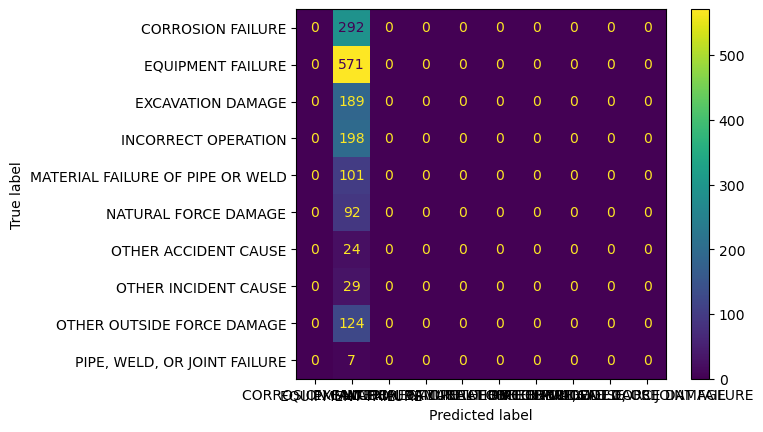

In [7]:
ConfusionMatrixDisplay(confusion_matrix(y_valid, y_pred_dummy, labels=dummy.classes_), display_labels=dummy.classes_).plot()

To idziemy dalej i sprobujmy przewidywać logistyczną regresją.

In [8]:
log_reg = LogisticRegression(penalty='l2', multi_class='multinomial', max_iter=150)
log_reg.fit(X_train, y_train)
y_log_reg_pred = log_reg.predict(X_valid)
print(classification_report(y_valid, y_log_reg_pred))

                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.46      0.50      0.48       292
               EQUIPMENT FAILURE       0.58      0.86      0.69       571
               EXCAVATION DAMAGE       0.54      0.60      0.57       189
             INCORRECT OPERATION       0.33      0.02      0.04       198
MATERIAL FAILURE OF PIPE OR WELD       0.34      0.44      0.38       101
            NATURAL FORCE DAMAGE       0.17      0.01      0.02        92
            OTHER ACCIDENT CAUSE       0.00      0.00      0.00        24
            OTHER INCIDENT CAUSE       0.71      0.17      0.28        29
      OTHER OUTSIDE FORCE DAMAGE       0.49      0.39      0.43       124
    PIPE, WELD, OR JOINT FAILURE       0.00      0.00      0.00         7

                        accuracy                           0.52      1627
                       macro avg       0.36      0.30      0.29      1627
                    weighted avg    

In [9]:
pd.DataFrame(data=np.sort(log_reg.coef_, axis=1), index=list(np.unique(y_log_reg_pred)).remove('PIPE, WELD, OR JOINT FAILURE'), columns=X.columns)

,case_lat,case_lon,case_date,FEDERAL,inst_age_in_days,MOP_PSIG,TAVG,case_date_sin,COMMODITY_RELEASED_TYPE_BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS),COMMODITY_RELEASED_TYPE_CO2 (CARBON DIOXIDE),...,PIPELINE_FUNCTION_TYPE B GATHERING,PIPELINE_FUNCTION_TYPE C GATHERING,zone_Cold,zone_Hot-Dry,zone_Hot-Humid,zone_Marine,zone_Mixed-Dry,zone_Mixed-Humid,zone_Subarctic,zone_Very Cold
0,-0.705443,-0.606210,-0.433006,-0.354647,-0.354125,-0.350667,-0.305123,-0.252274,-0.228217,-0.225215,...,0.154983,0.176732,0.187899,0.224167,0.257307,0.262766,0.324128,0.333602,0.374225,0.540151
1,-0.692635,-0.505389,-0.443821,-0.404907,-0.362358,-0.353426,-0.323538,-0.192839,-0.180370,-0.121263,...,0.237221,0.262441,0.269666,0.304365,0.309557,0.310847,0.313100,0.322313,0.485430,0.493414
2,-0.595304,-0.473182,-0.379604,-0.362319,-0.348041,-0.285931,-0.270372,-0.243696,-0.171902,-0.147248,...,0.192811,0.219088,0.226541,0.273460,0.306069,0.308446,0.328902,0.396434,0.414960,0.540452
3,-0.482923,-0.454222,-0.343277,-0.336297,-0.318539,-0.300338,-0.273297,-0.220325,-0.213550,-0.185156,...,0.168317,0.180505,0.182531,0.193030,0.194404,0.212450,0.220652,0.235050,0.259308,0.321890
4,-0.580561,-0.521163,-0.433609,-0.433431,-0.398682,-0.394402,-0.373054,-0.363871,-0.344082,-0.280849,...,0.122204,0.173506,0.178231,0.267278,0.278894,0.361008,0.375792,0.443016,0.542208,0.566406
5,-0.211021,-0.201551,-0.181182,-0.178817,-0.161192,-0.136573,-0.136383,-0.131047,-0.130265,-0.118214,...,0.132115,0.134980,0.140560,0.143745,0.161192,0.185504,0.197609,0.207478,0.227769,0.370425
6,-0.849646,-0.837523,-0.608856,-0.499817,-0.488261,-0.428719,-0.290583,-0.282555,-0.237102,-0.227537,...,0.224675,0.238313,0.240709,0.295270,0.302034,0.398484,0.406998,0.426268,0.464751,0.467604
7,-0.511318,-0.505722,-0.373128,-0.357538,-0.357035,-0.338047,-0.334898,-0.330890,-0.311741,-0.259471,...,0.213961,0.249647,0.260737,0.296939,0.297968,0.306920,0.340719,0.360265,0.567979,0.720027
8,-0.516085,-0.382224,-0.309877,-0.305208,-0.216122,-0.205502,-0.205473,-0.186732,-0.179397,-0.166193,...,0.152041,0.166911,0.169007,0.185286,0.214566,0.216122,0.238292,0.273824,0.330990,0.519090
9,-0.439900,-0.411943,-0.410975,-0.392468,-0.380398,-0.267738,-0.231094,-0.214839,-0.212977,-0.171943,...,0.252760,0.292532,0.330392,0.338704,0.358124,0.394264,0.418951,0.432417,0.440045,0.549931


Widać że linijowy model źle się dopasował, zatem sprobujmy najpierw zastosować SVC z jądrem. On się pokazał źle, dlatego wykorzystajmy zwykły linijowy SVC z hinge loss.

In [10]:
svc = SVC(kernel='rbf', random_state=SEED)
svc.fit(X_train, y_train)
y_log_reg_pred = svc.predict(X_valid)
print(classification_report(y_valid, y_log_reg_pred))

                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.50      0.48      0.49       292
               EQUIPMENT FAILURE       0.58      0.87      0.70       571
               EXCAVATION DAMAGE       0.54      0.57      0.56       189
             INCORRECT OPERATION       0.33      0.01      0.01       198
MATERIAL FAILURE OF PIPE OR WELD       0.33      0.54      0.41       101
            NATURAL FORCE DAMAGE       0.29      0.02      0.04        92
            OTHER ACCIDENT CAUSE       0.00      0.00      0.00        24
            OTHER INCIDENT CAUSE       1.00      0.07      0.13        29
      OTHER OUTSIDE FORCE DAMAGE       0.43      0.38      0.40       124
    PIPE, WELD, OR JOINT FAILURE       0.00      0.00      0.00         7

                        accuracy                           0.52      1627
                       macro avg       0.40      0.29      0.27      1627
                    weighted avg    

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Sprobujmy polepszyć wynik za pomocą bardziej złożonych modeli, takich jak MLP

In [11]:
# params = {"hidden_layer_sizes": [(np.ones(50) * 50).astype(int), (np.ones(100) * 100).astype(int)], 'alpha': [0.0001, 0.001, 0.01]}
# mlp_classifier = MLPClassifier(activation='relu', solver= 'sgd', learning_rate='adaptive',
#           momentum=0.7, nesterovs_momentum=True, early_stopping=True)
# grid_search_cv = GridSearchCV(mlp_classifier, param_grid=params, cv=5)
# grid_search_cv.fit(X_train, y_train)

Najlepsze parametry:
`{'alpha': 0.0001,
 'hidden_layer_sizes': (np.ones(50) * 50).astype(int)}`

In [12]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, y_train)

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [13]:
y_mlp_classifier_pred = mlp_classifier.predict(X_valid)
print(classification_report(y_valid, y_mlp_classifier_pred))

                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.45      0.51      0.48       292
               EQUIPMENT FAILURE       0.60      0.79      0.68       571
               EXCAVATION DAMAGE       0.45      0.53      0.49       189
             INCORRECT OPERATION       0.29      0.11      0.16       198
MATERIAL FAILURE OF PIPE OR WELD       0.37      0.33      0.35       101
            NATURAL FORCE DAMAGE       0.10      0.04      0.06        92
            OTHER ACCIDENT CAUSE       0.20      0.04      0.07        24
            OTHER INCIDENT CAUSE       0.46      0.21      0.29        29
      OTHER OUTSIDE FORCE DAMAGE       0.41      0.30      0.34       124
    PIPE, WELD, OR JOINT FAILURE       0.07      0.14      0.10         7

                        accuracy                           0.49      1627
                       macro avg       0.34      0.30      0.30      1627
                    weighted avg    

In [14]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)
tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_valid)
print(classification_report(y_valid, y_tree_pred))

                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.44      0.43      0.44       292
               EQUIPMENT FAILURE       0.56      0.74      0.64       571
               EXCAVATION DAMAGE       0.53      0.55      0.54       189
             INCORRECT OPERATION       0.25      0.14      0.18       198
MATERIAL FAILURE OF PIPE OR WELD       0.31      0.44      0.36       101
            NATURAL FORCE DAMAGE       0.27      0.08      0.12        92
            OTHER ACCIDENT CAUSE       0.00      0.00      0.00        24
            OTHER INCIDENT CAUSE       0.06      0.03      0.04        29
      OTHER OUTSIDE FORCE DAMAGE       0.43      0.26      0.32       124
    PIPE, WELD, OR JOINT FAILURE       0.17      0.14      0.15         7

                        accuracy                           0.47      1627
                       macro avg       0.30      0.28      0.28      1627
                    weighted avg    

[Text(0.5653479064039408, 0.9444444444444444, 'LOCATION_TYPE_TOTALLY CONTAINED ON OPERATOR-CONTROLLED PROPERTY <= 0.037\ngini = 0.796\nsamples = 4880\nvalue = [850.0, 1803.0, 478.0, 578.0, 314.0, 273.0, 57.0, 88.0\n373.0, 66.0]\nclass = EQUIPMENT FAILURE'),
 Text(0.35252463054187194, 0.8333333333333334, 'LOCATION_TYPE_OPERATOR-CONTROLLED PROPERTY <= 1.407\ngini = 0.854\nsamples = 2530\nvalue = [366.0, 566.0, 463.0, 200.0, 257.0, 164.0, 16.0, 85.0\n347.0, 66.0]\nclass = EQUIPMENT FAILURE'),
 Text(0.21428571428571427, 0.7222222222222222, 'MATERIAL_INVOLVED_CARBON STEEL <= -0.439\ngini = 0.856\nsamples = 2079\nvalue = [351, 283, 459, 147, 243, 127, 16, 67, 320, 66]\nclass = EXCAVATION DAMAGE'),
 Text(0.12315270935960591, 0.6111111111111112, 'MATERIAL_INVOLVED_MATERIAL OTHER THAN CARBON STEEL <= 1.181\ngini = 0.803\nsamples = 896\nvalue = [23.0, 102.0, 264.0, 71.0, 3.0, 64.0, 1.0, 56.0, 246.0\n66.0]\nclass = EXCAVATION DAMAGE'),
 Text(0.07881773399014778, 0.5, 'LOCATION_TYPE_PRIVATE PROPER

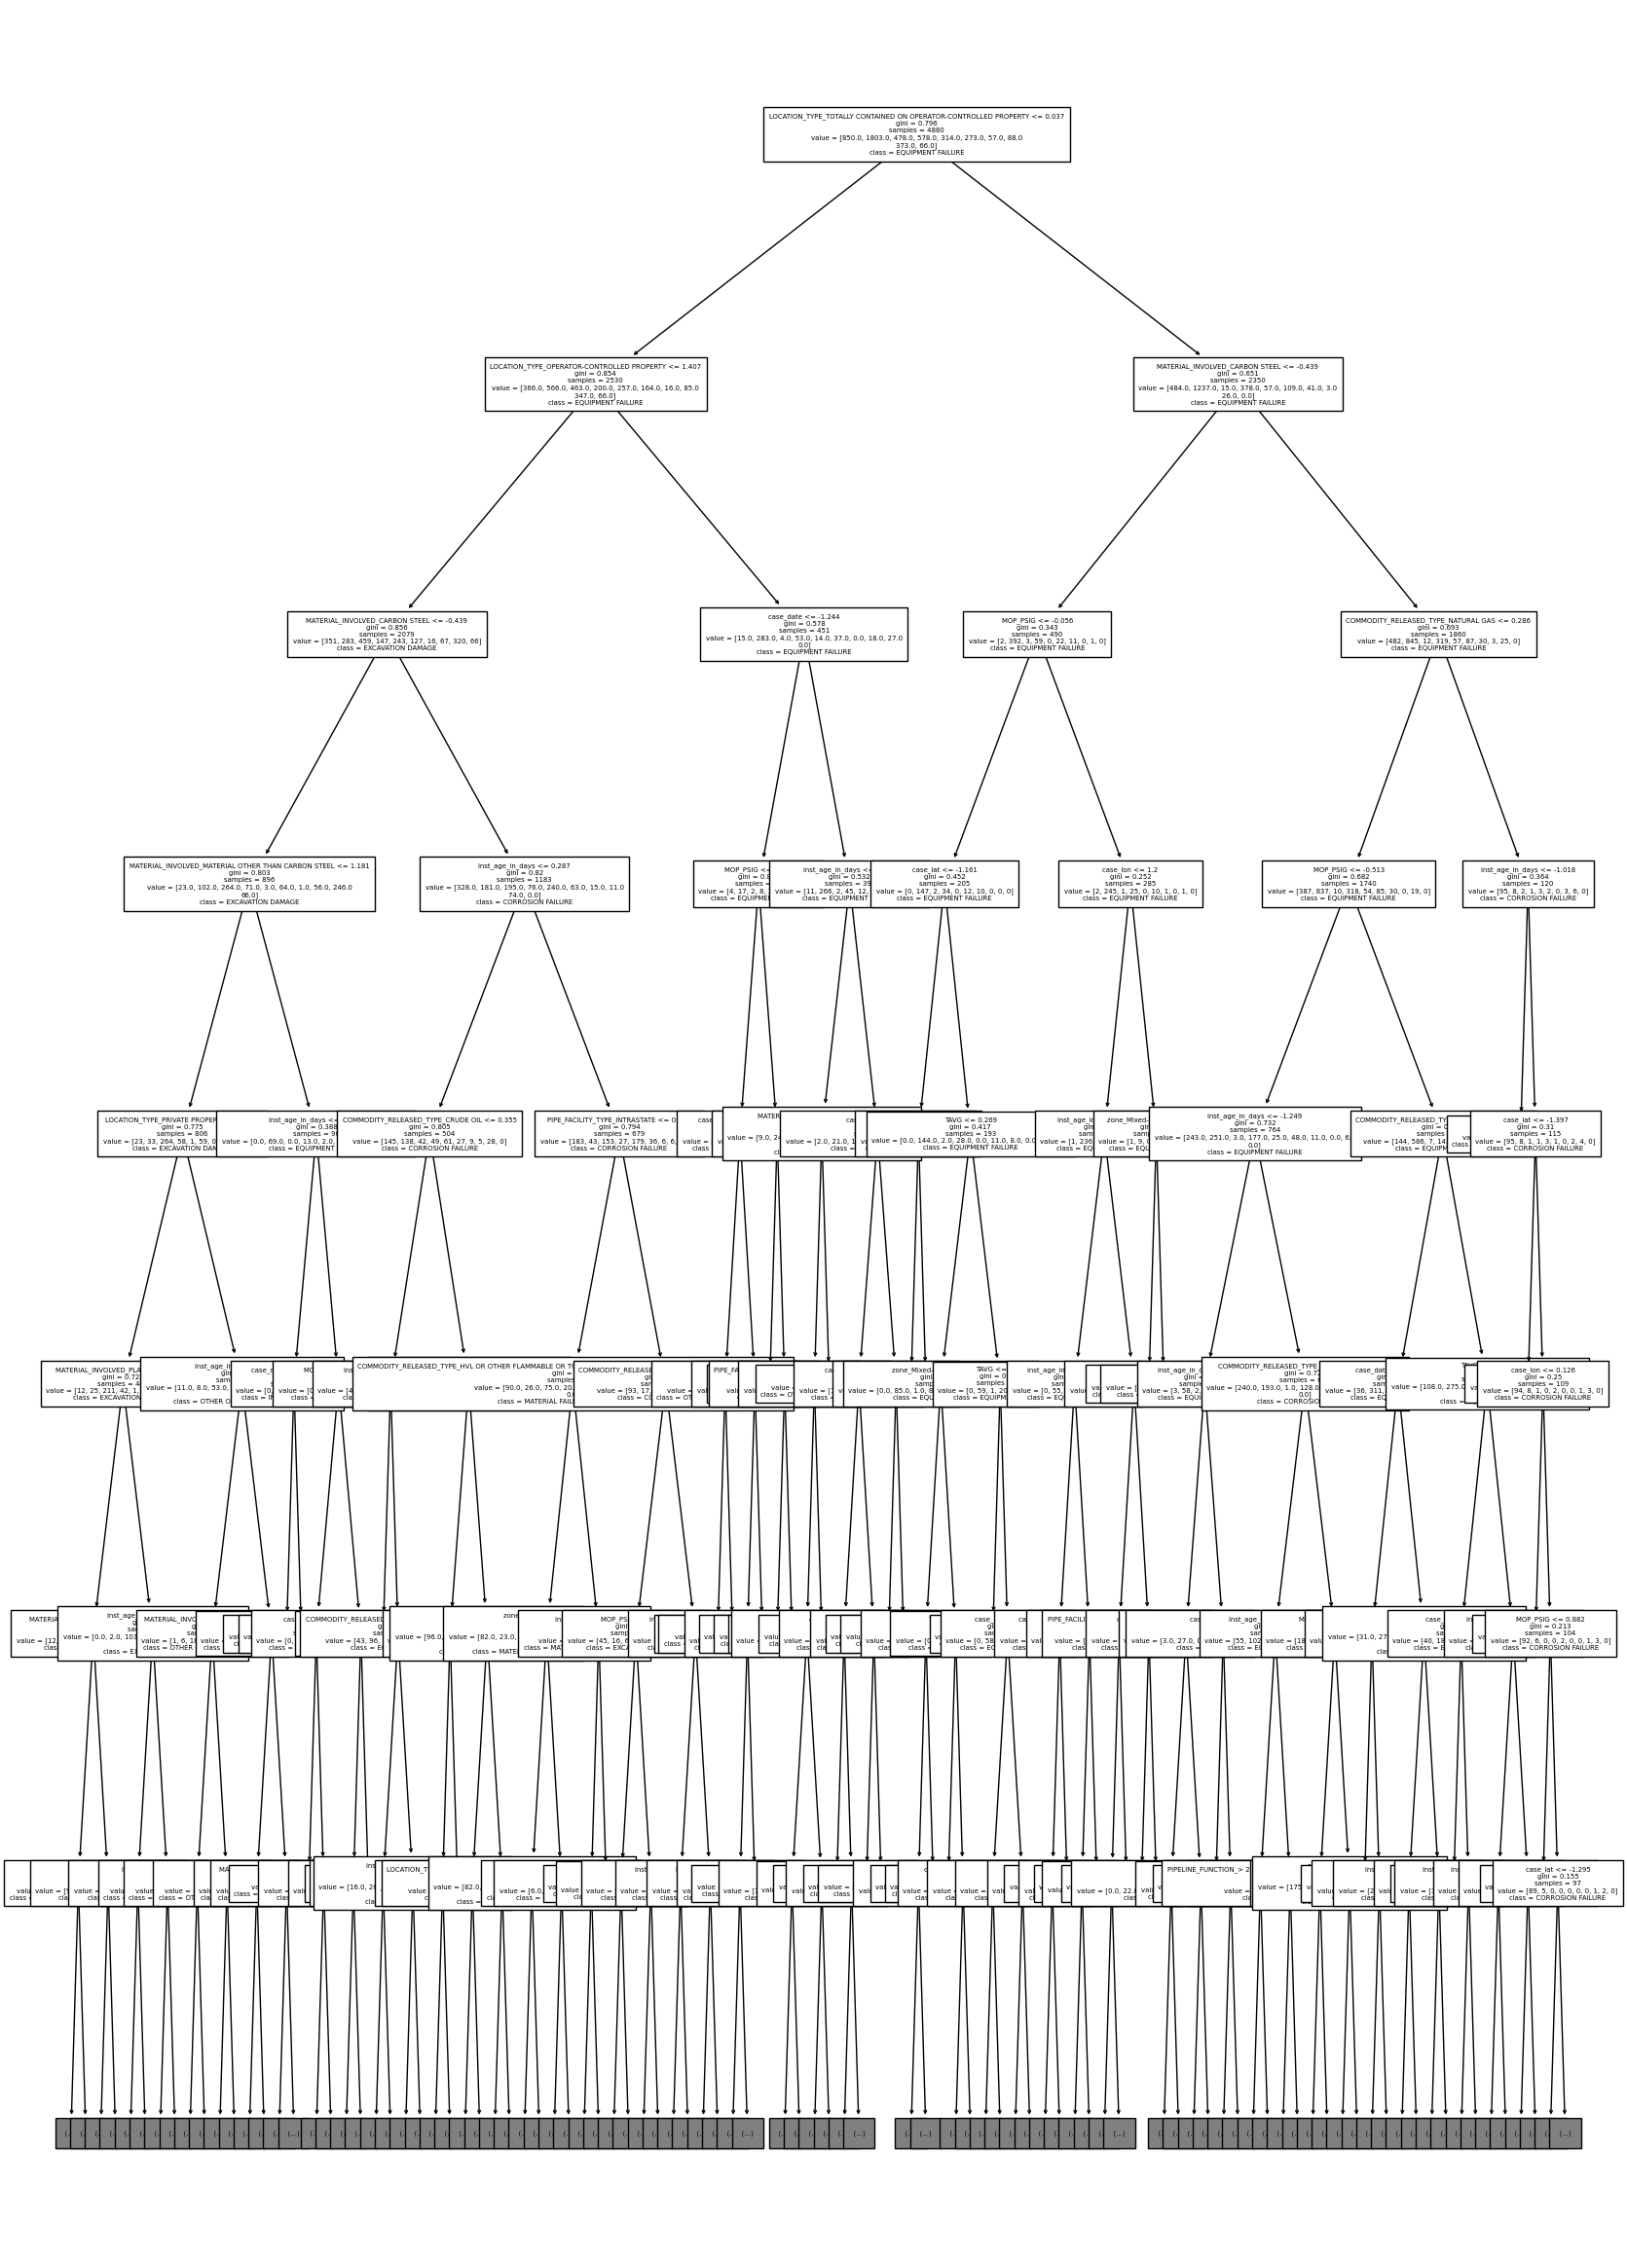

In [15]:
col_names_wo_target = list(df.columns)
col_names_wo_target.remove(classification_target)
fig, ax = plt.subplots()
fig.set_size_inches(20, 30)
plot_tree(tree, feature_names=col_names_wo_target, class_names=tree.classes_, ax=ax, max_depth=7,fontsize=5)

## Zaraz sprawdźmy wyniki z różnymi cechami: alg jest taki (zachłanny):
1. wyberzmy N, czyli liczbę parametrów
1. `cechy` = []
2. weźmy ten param, z którym dostaliśmy najlepszy przyrost F1 (ważony wg klasów)
3. róbmy tak w kółko, dopóki len(cechy) < N

In [16]:
cols = list(df.columns)
cols.remove(classification_target)
pd.DataFrame(X_test, columns=cols)

,case_lat,case_lon,case_date,FEDERAL,inst_age_in_days,MOP_PSIG,TAVG,case_date_sin,COMMODITY_RELEASED_TYPE_BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS),COMMODITY_RELEASED_TYPE_CO2 (CARBON DIOXIDE),...,PIPELINE_FUNCTION_TYPE B GATHERING,PIPELINE_FUNCTION_TYPE C GATHERING,zone_Cold,zone_Hot-Dry,zone_Hot-Humid,zone_Marine,zone_Mixed-Dry,zone_Mixed-Humid,zone_Subarctic,zone_Very Cold
0,0.704202,0.365454,0.852856,-0.109673,1.019752,-0.702960,0.040530,-1.277835,-0.024802,-0.09755,...,-0.028642,-0.045314,1.791794,-0.421433,-0.650504,-0.128277,-0.129917,-0.588393,-0.037901,-0.153264
1,-1.453256,-0.202524,0.192975,-0.109673,-1.120767,-0.751853,0.744264,1.385106,-0.024802,-0.09755,...,-0.028642,-0.045314,-0.558100,-0.421433,1.537270,-0.128277,-0.129917,-0.588393,-0.037901,-0.153264
2,-0.721681,-0.832893,-0.598207,-0.109673,1.325919,0.218779,0.034285,1.273775,-0.024802,-0.09755,...,-0.028642,-0.045314,-0.558100,2.372854,-0.650504,-0.128277,-0.129917,-0.588393,-0.037901,-0.153264
3,-0.994671,-0.059421,1.257731,-0.109673,-1.400558,1.361446,-1.243965,1.225341,-0.024802,-0.09755,...,-0.028642,-0.045314,-0.558100,-0.421433,1.537270,-0.128277,-0.129917,-0.588393,-0.037901,-0.153264
4,-0.091151,0.079987,1.141289,-0.109673,-0.959355,-0.739177,1.138644,-1.423627,-0.024802,-0.09755,...,-0.028642,-0.045314,-0.558100,-0.421433,-0.650504,-0.128277,-0.129917,1.699543,-0.037901,-0.153264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,-1.677470,-0.344785,-0.339433,-0.109673,-1.349699,0.745746,0.356130,1.376707,-0.024802,-0.09755,...,-0.028642,-0.045314,-0.558100,-0.421433,1.537270,-0.128277,-0.129917,-0.588393,-0.037901,-0.153264
1623,-1.025085,0.170669,-0.868845,-0.109673,-0.156681,-0.005963,-1.243965,1.273775,-0.024802,-0.09755,...,-0.028642,-0.045314,-0.558100,-0.421433,1.537270,-0.128277,-0.129917,-0.588393,-0.037901,-0.153264
1624,0.859740,1.864129,1.521695,-0.109673,0.810887,0.383569,-1.206497,1.108831,-0.024802,-0.09755,...,-0.028642,-0.045314,-0.558100,-0.421433,-0.650504,-0.128277,-0.129917,1.699543,-0.037901,-0.153264
1625,-0.565050,-1.958485,-0.527767,-0.109673,0.554318,-1.146626,0.838416,-0.657897,-0.024802,-0.09755,...,-0.028642,-0.045314,-0.558100,2.372854,-0.650504,-0.128277,-0.129917,-0.588393,-0.037901,-0.153264


In [17]:
feature_names = ['case_lat', 'case_lon', 'case_date', 'FEDERAL', 'inst_age_in_days',
       'MOP_PSIG', 'TAVG', 'case_date_sin', 'COMMODITY_RELEASED_TYPE', 'ON_OFF_SHORE', 'LOCATION_TYPE', 'MATERIAL_INVOLVED', 'PIPE_FACILITY_TYPE', 'PIPELINE_FUNCTION',
       'zone']
def greedy_feature_search(model, X_train, X_valid, y_train, y_valid, orig_columns_wo_target, features):
    best_features = []
    best_features_unonehotted = []
    best_f1 = 0
    for i in range(len(features)):
        current_set_max_f1 = 0
        current_set_max_f1_names = None
        current_set_max_f1_name = None
        for feature in features:
              current_features = []
              for col_name in orig_columns_wo_target:
                   if col_name.startswith(feature):
                        current_features.append(col_name)
              
              current_train_df = pd.DataFrame(X_train, columns=orig_columns_wo_target).loc[:, best_features + current_features]
              current_valid_df = pd.DataFrame(X_valid, columns=orig_columns_wo_target).loc[:, best_features + current_features]
              model = sklearn.base.clone(model)
              model.fit(current_train_df, y_train)
              y_pred = model.predict(current_valid_df)
              current_f1 = f1_score(y_valid, y_pred, average='weighted')
              if current_f1 > current_set_max_f1 and feature not in best_features_unonehotted:
                  current_set_max_f1 = current_f1
                  current_set_max_f1_names = current_features
                  current_set_max_f1_name = feature
        print(f'{i+1} iteration best feature is {current_set_max_f1_name} with f1 score = {current_set_max_f1}\n')
        if current_set_max_f1 > best_f1:
             best_f1 = current_set_max_f1
             best_features += current_set_max_f1_names
             best_features_unonehotted.append(current_set_max_f1_name)
        else:
             print(f'prev score {best_f1} is better than the current one {current_set_max_f1}, stopping')
             return best_features
        # best_f1 = current_set_max_f1
        # best_features += current_set_max_f1_names
    return best_features
            

In [18]:
col_names_wo_target = list(df.columns)
col_names_wo_target.remove(classification_target)
best_features_greedy = greedy_feature_search(log_reg, X_train, X_valid, y_train, y_valid, col_names_wo_target, feature_names)

1 iteration best feature is LOCATION_TYPE with f1 score = 0.3817809080281881

2 iteration best feature is zone with f1 score = 0.40000122685514633

3 iteration best feature is MATERIAL_INVOLVED with f1 score = 0.4196618019212822

4 iteration best feature is COMMODITY_RELEASED_TYPE with f1 score = 0.4349019941529137

5 iteration best feature is inst_age_in_days with f1 score = 0.4441964340608353

6 iteration best feature is PIPE_FACILITY_TYPE with f1 score = 0.4560658054228293

7 iteration best feature is case_lon with f1 score = 0.4629478613888541

8 iteration best feature is PIPELINE_FUNCTION with f1 score = 0.4654519339326641

9 iteration best feature is case_date_sin with f1 score = 0.47180466041093344

10 iteration best feature is FEDERAL with f1 score = 0.47307812793828463

11 iteration best feature is MOP_PSIG with f1 score = 0.47382274531267804

12 iteration best feature is TAVG with f1 score = 0.47114592118815585

prev score 0.47382274531267804 is better than the current one 0.

Możemy na razie zostawić **model drzewowy**, ponieważ weighted avg tu jest lepszy niż w każdym innym modelu.

Sprawdźmy ważność każdej cechy.

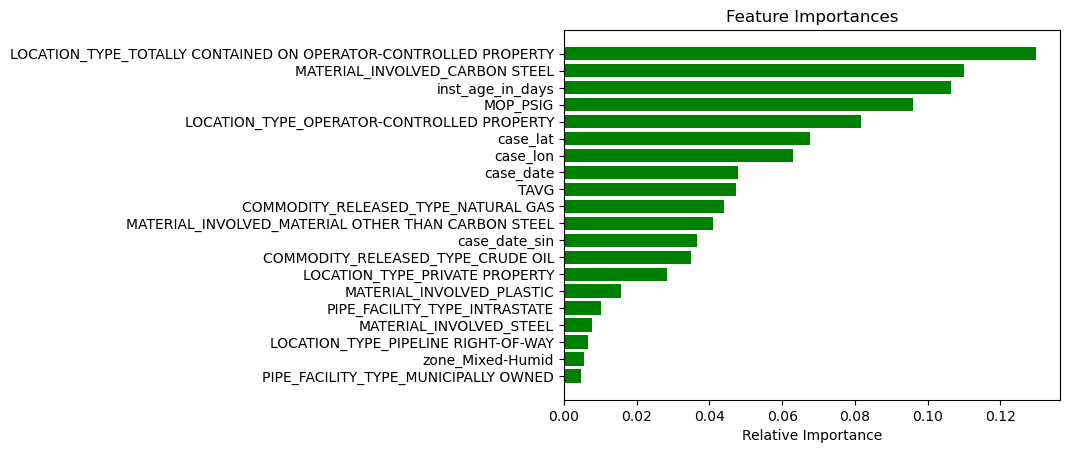

In [19]:
t֫ree_feature_importances = tree.feature_importances_
indices = np.argsort(t֫ree_feature_importances)[-20:]
features = df.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), t֫ree_feature_importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


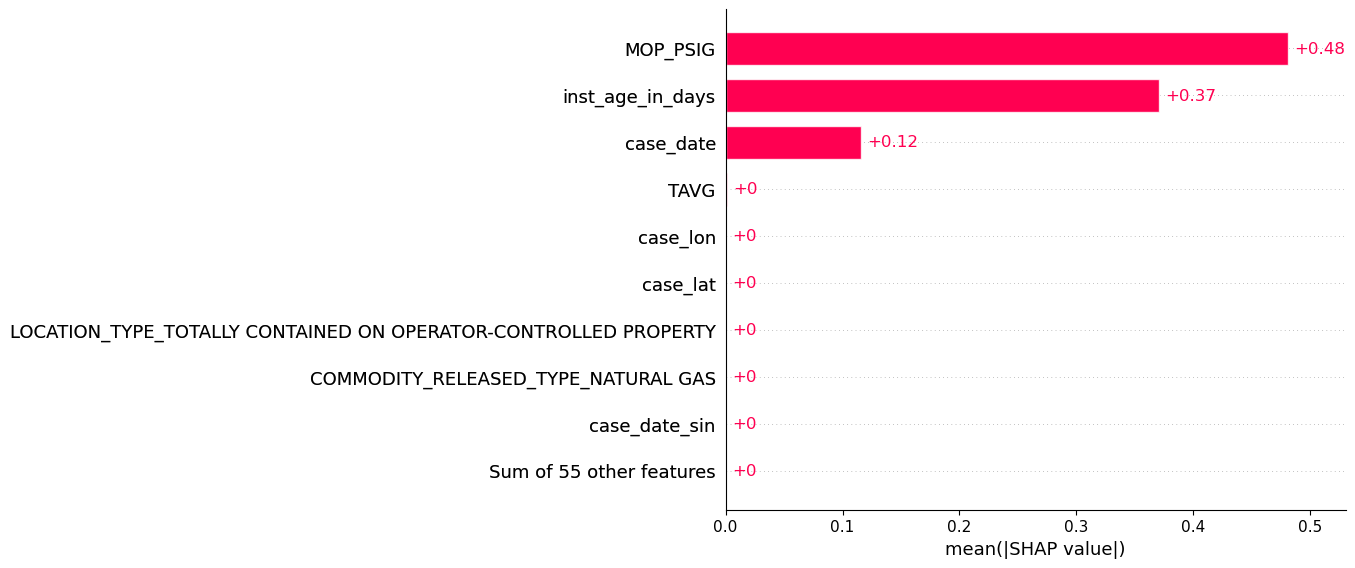

In [141]:
log_reg = LogisticRegression(penalty='l2', multi_class='multinomial', solver='saga')
log_reg.fit(X_train, y_train)
shap.initjs()
samples = X_valid
explainer = shap.Explainer(log_reg, samples)
shap_values = explainer(samples)
shap_pred_log_reg = log_reg.predict(samples)
new_shap_values = []
for i, pred in enumerate(shap_pred_log_reg):
    pred_class_number = list(log_reg.classes_).index(pred)
    new_shap_values.append(shap_values.values[i][:, pred_class_number])
shap_values.values = np.array(new_shap_values)
shap.plots.bar(shap_values)

In [137]:
log_reg = LogisticRegression(penalty='l2', multi_class='multinomial', max_iter=150)
X_train_shap_reduced = X_train.loc[:, ['MOP_PSIG', 'inst_age_in_days', 'case_date']]
X_valid_shap_reduced = X_valid.loc[:, ['MOP_PSIG', 'inst_age_in_days', 'case_date']]
log_reg.fit(X_train_shap_reduced, y_train)
shap_pred_log_reg = log_reg.predict(X_valid_shap_reduced)
print(classification_report(y_valid, shap_pred_log_reg))

                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.36      0.25      0.29       300
               EQUIPMENT FAILURE       0.43      0.93      0.59       599
               EXCAVATION DAMAGE       0.32      0.20      0.25       169
             INCORRECT OPERATION       0.00      0.00      0.00       183
MATERIAL FAILURE OF PIPE OR WELD       0.29      0.02      0.04        95
            NATURAL FORCE DAMAGE       0.00      0.00      0.00        93
            OTHER ACCIDENT CAUSE       0.00      0.00      0.00        17
            OTHER INCIDENT CAUSE       0.00      0.00      0.00        32
      OTHER OUTSIDE FORCE DAMAGE       0.00      0.00      0.00       126
    PIPE, WELD, OR JOINT FAILURE       0.00      0.00      0.00        13

                        accuracy                           0.41      1627
                       macro avg       0.14      0.14      0.12      1627
                    weighted avg    

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/m

In [ ]:
X_train_best_greedy = pd.DataFrame(X_train, columns=col_names_wo_target).loc[:, best_features_greedy]
X_valid_best_greedy = pd.DataFrame(X_valid, columns=col_names_wo_target).loc[:, best_features_greedy]
log_reg = sklearn.base.clone(log_reg)
log_reg.fit(X_train_best_greedy, y_train)
y_pred_greedy_best_params_log_reg = log_reg.predict(X_valid_best_greedy)
print(f'greedy best 42 features classification report')
print(classification_report(y_valid, y_pred_greedy_best_params_log_reg))

greedy best 42 features classification report
                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.50      0.54      0.52       313
               EQUIPMENT FAILURE       0.58      0.89      0.71       576
               EXCAVATION DAMAGE       0.51      0.56      0.53       162
             INCORRECT OPERATION       0.50      0.01      0.02       187
MATERIAL FAILURE OF PIPE OR WELD       0.36      0.41      0.38        93
            NATURAL FORCE DAMAGE       0.50      0.03      0.06        91
            OTHER ACCIDENT CAUSE       0.00      0.00      0.00        18
            OTHER INCIDENT CAUSE       0.75      0.15      0.25        40
      OTHER OUTSIDE FORCE DAMAGE       0.51      0.41      0.45       128
    PIPE, WELD, OR JOINT FAILURE       0.00      0.00      0.00        19

                        accuracy                           0.54      1627
                       macro avg       0.42      0.30      0.29 

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Wynik f1 weighted avg o 1% lepszy niż w przypadku z 42 najlepszymi cechami według algorytmu zachlanego, niż z tymi 42 najlepszymi cechami wg `feature_importances_` z sklearn oraz o 17% lepszy niż z najlepszymi wartościami SHAPey 

In [152]:
(y_valid == log_reg.classes_[0]).argmax()

3

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


class CORROSION FAILURE


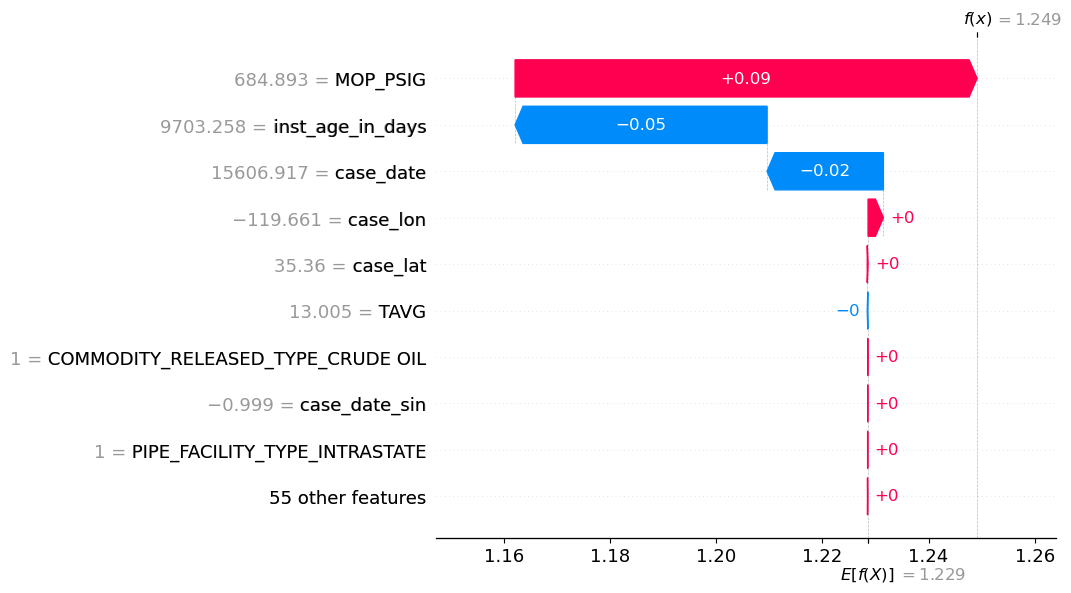

class EQUIPMENT FAILURE


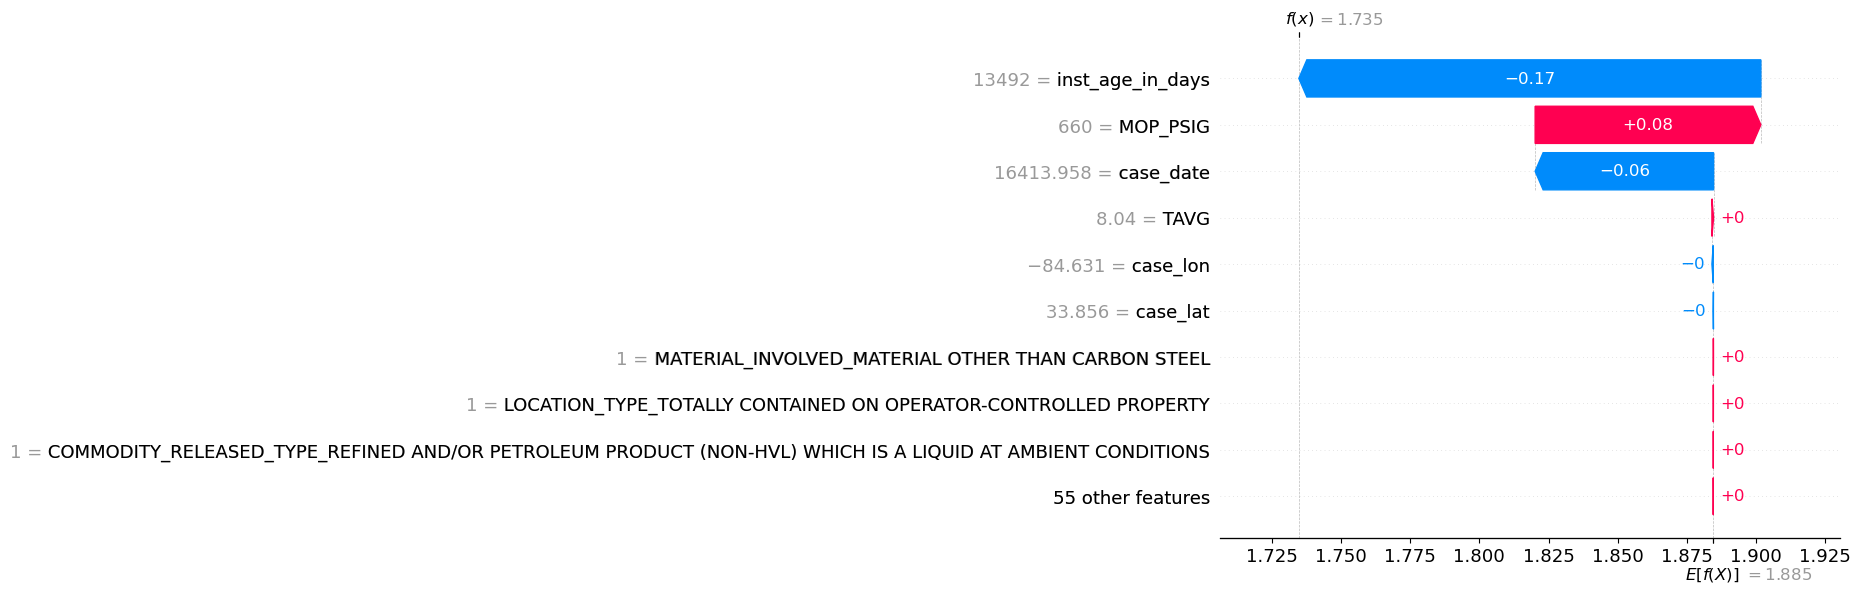

class EXCAVATION DAMAGE


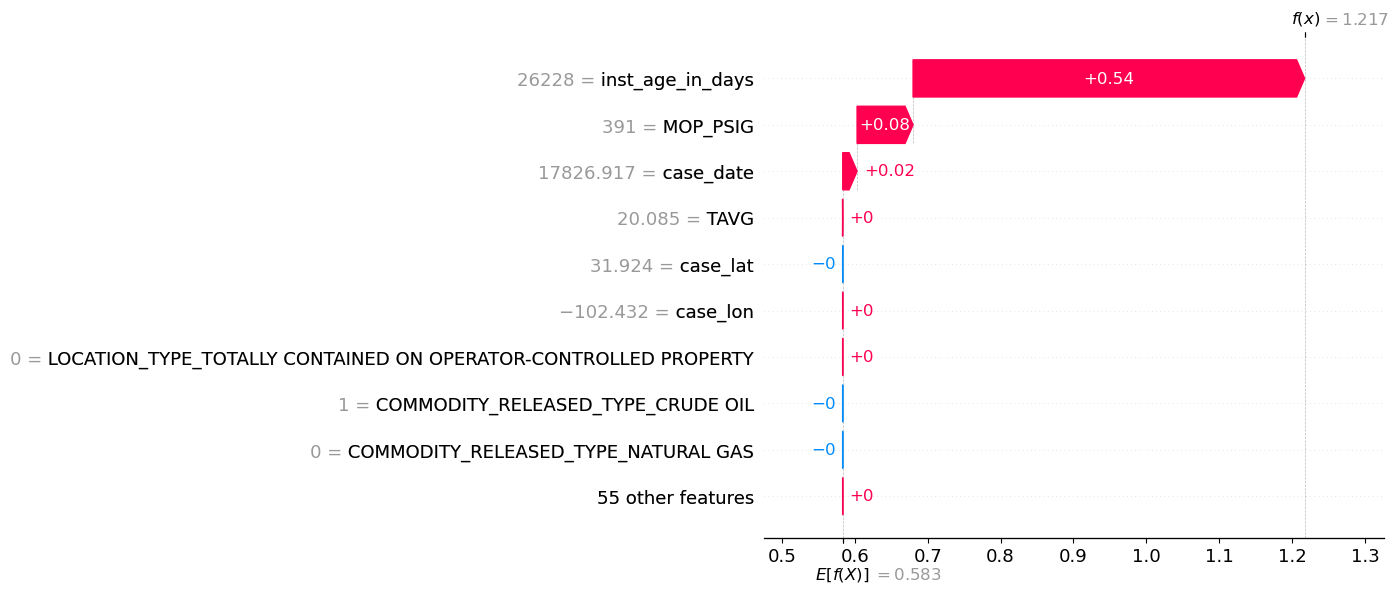

class INCORRECT OPERATION


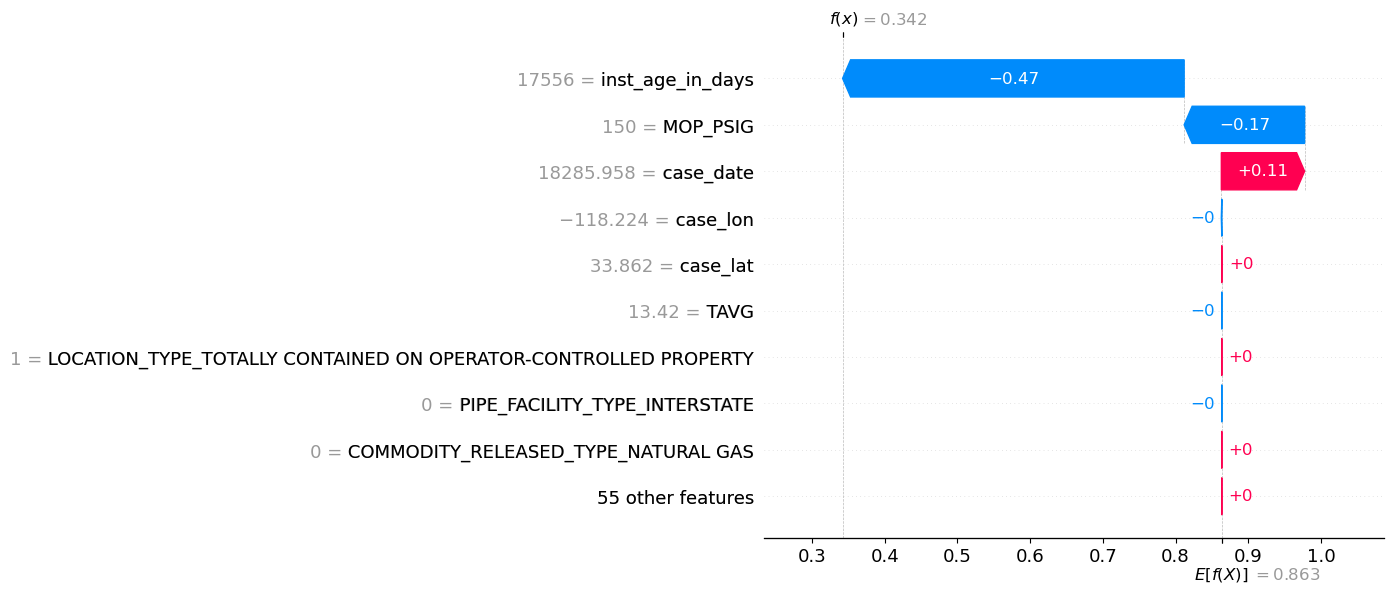

class MATERIAL FAILURE OF PIPE OR WELD


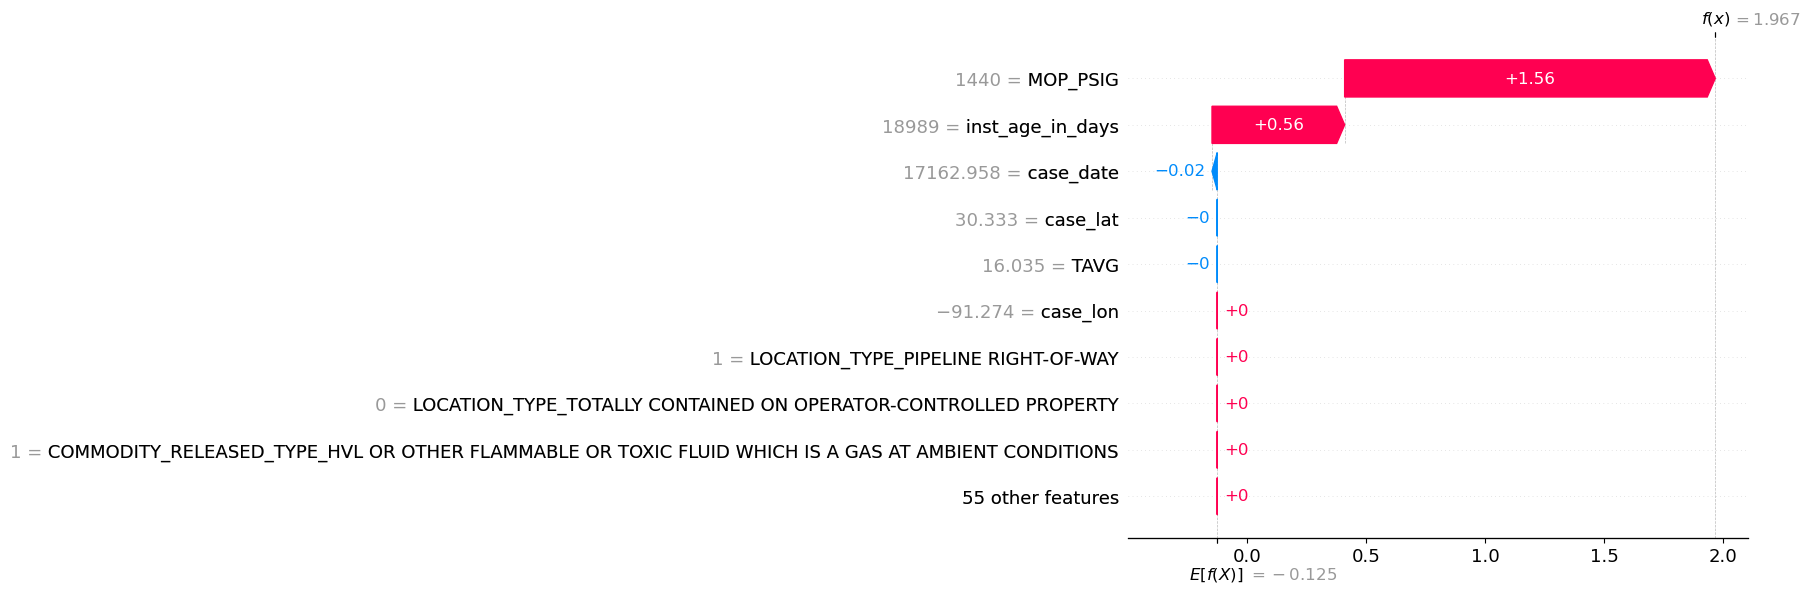

class NATURAL FORCE DAMAGE


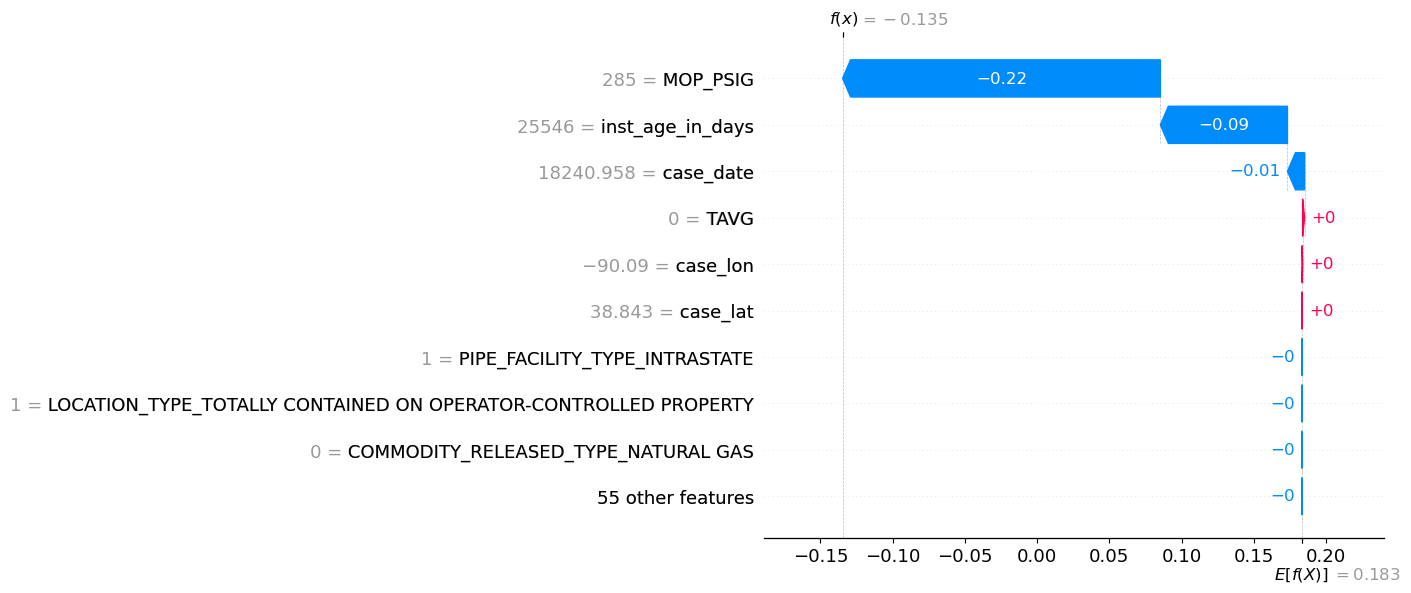

class OTHER ACCIDENT CAUSE


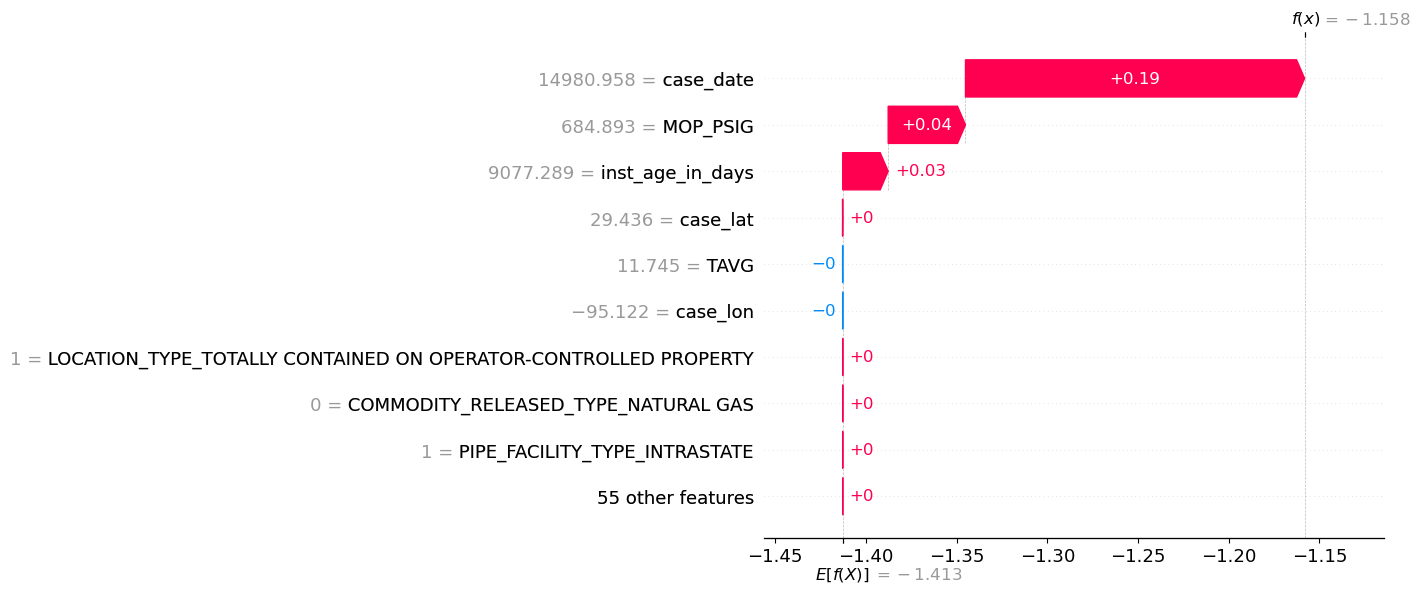

class OTHER INCIDENT CAUSE


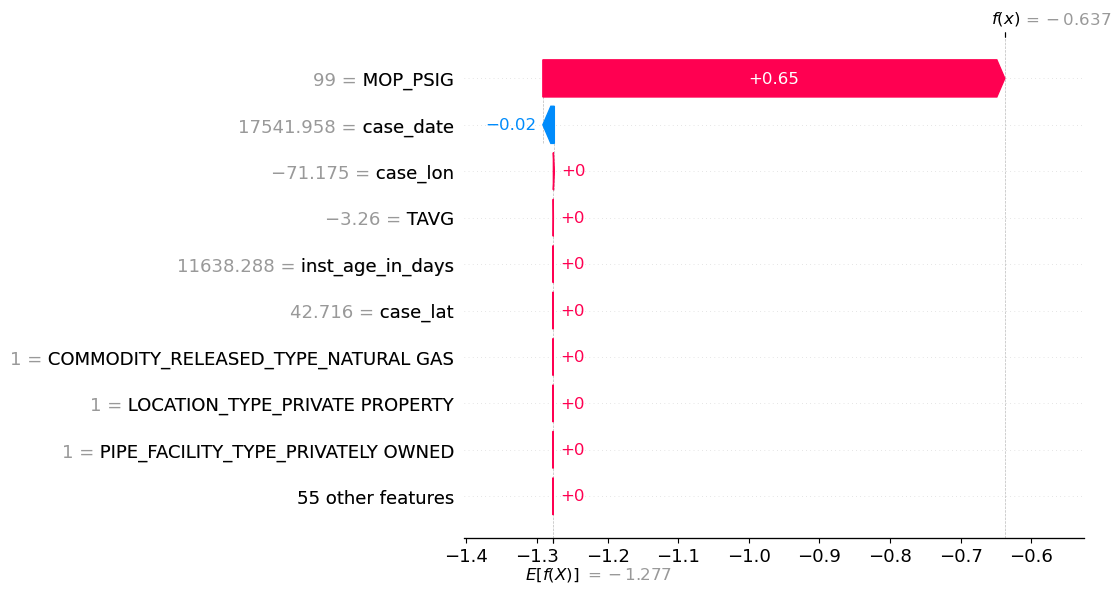

class OTHER OUTSIDE FORCE DAMAGE


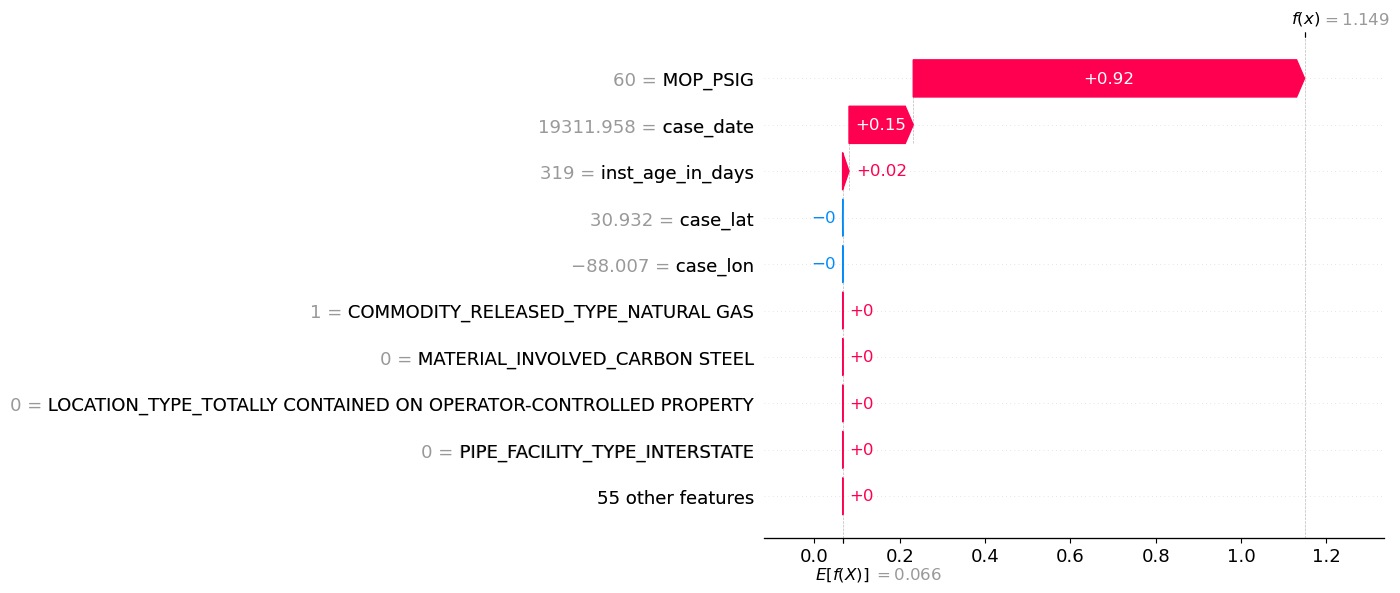

class PIPE, WELD, OR JOINT FAILURE


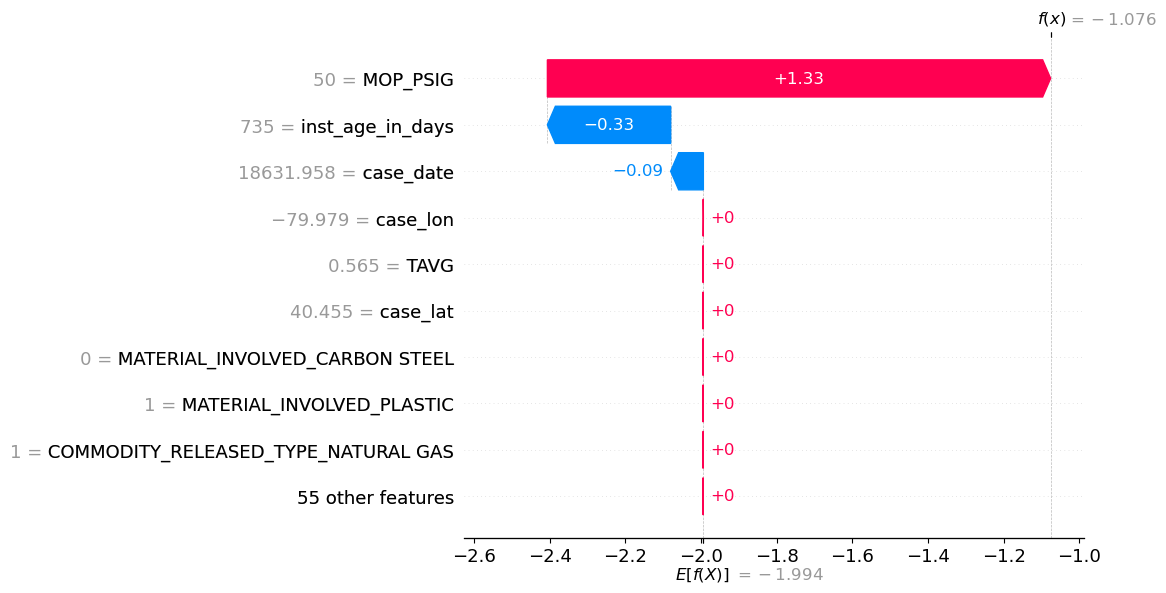

In [156]:
log_reg = LogisticRegression(penalty='l2', multi_class='multinomial', max_iter=150)
log_reg.fit(X_train, y_train)
shap.initjs()
samples = X_valid
explainer = shap.Explainer(log_reg, samples)
shap_values = explainer(samples)
print(f'class {log_reg.classes_[0]}')
shap.plots.waterfall(shap_values[(y_valid == log_reg.classes_[0]).argmax(), :, 0])
print(f'class {log_reg.classes_[1]}')
shap.plots.waterfall(shap_values[(y_valid == log_reg.classes_[1]).argmax(), :, 1])
print(f'class {log_reg.classes_[2]}')
shap.plots.waterfall(shap_values[(y_valid == log_reg.classes_[2]).argmax(), :, 2])
print(f'class {log_reg.classes_[3]}')
shap.plots.waterfall(shap_values[(y_valid == log_reg.classes_[3]).argmax(), :, 3])
print(f'class {log_reg.classes_[4]}')
shap.plots.waterfall(shap_values[(y_valid == log_reg.classes_[4]).argmax(), :, 4])
print(f'class {log_reg.classes_[5]}')
shap.plots.waterfall(shap_values[(y_valid == log_reg.classes_[5]).argmax(), :, 5])
print(f'class {log_reg.classes_[6]}')
shap.plots.waterfall(shap_values[(y_valid == log_reg.classes_[6]).argmax(), :, 6])
print(f'class {log_reg.classes_[7]}')
shap.plots.waterfall(shap_values[(y_valid == log_reg.classes_[7]).argmax(), :, 7])
print(f'class {log_reg.classes_[8]}')
shap.plots.waterfall(shap_values[(y_valid == log_reg.classes_[8]).argmax(), :, 8])
print(f'class {log_reg.classes_[9]}')
shap.plots.waterfall(shap_values[(y_valid == log_reg.classes_[9]).argmax(), :, 9])